<a href="https://colab.research.google.com/github/derykroot/Aprendizadocontinuoincremental/blob/main/2_AprendizadoContinuo_IncrClasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Incremento de Novas Classes**

No cenário anterior o problema era melhorar o desempenho na classificação de conjuntos com treinamento de mais exemplares dos mesmos conjuntos. Como exemplificado, no primeiro treino existia apenas os números 1 inclinados para a direita, ao passo que não classificava os números 1 inclinados para esquerda até fazer outro treino com amostras contendo exemplares com as caracteristicas necessárias para classificar tambem os números 1 inclinados para esquerda.
Outro problema no aprendizado continuo é quando desejamos adicionar mais classes, por exemplo, treinamos uma rede para diferenciar um gato de um cachorro, mas desejamos incluir tambem um outro animal em uma rede neural já treinada, isso tambem vai resultar em um Esquecimento Catastrófico. No problema exemplificado a seguir é realizado primeiramente o treinamento para classificar os numeros 1 e 2. Depois é incluido uma nova classe para classificar os numeros 1, 2 e 3 e realizamos outro treinamento

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
!wget https://github.com/derykroot/Aprendizadocontinuoincremental/blob/main/datasets.tar.gz?raw=true -O datasets.tar.gz
!tar xzf datasets.tar.gz

Funções de auxilio

In [ ]:
def showimgs(imgs):
  fig, ax = plt.subplots(1, len(imgs), figsize=(15,15))
  #fig, ax = plt.subplots(1, len(imgs))
  for i in range(len(imgs)):
    ax[i].imshow(imgs[i])
    ax[i].axis('off')
  plt.show()

def showparts(imgs, nparts = 4):
    ishow = []
    for i in range(len(imgs)):
        ishow.append(imgs[i])
        if ((i+1) % nparts) == 0:
            showimgs(ishow)
            ishow = []

# Dataset

Usaremos 2 Datasets para treino. O Primeiro dataset é o mesmo do problema abordado anteriormente contendo 100 amostras de manuscritos do numero *1* que estão inclinados para direita e 100 amostras do numero *2*, e mais 50 amostras de cada respectivamente para validação do treino.
O Segundo dataset contem 50 amostras novas para treino mais 25 de cada para validação. Foi incluido tambem mais 100 amostras para treino da nova classe para classificação do numero *3* junto com mais 50 imagens para validação 

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((48,48), transforms.InterpolationMode.BICUBIC),
        transforms.Grayscale(),
        transforms.ToTensor()
    ]
)

tset = datasets.ImageFolder('./datasets/ds/train',  transform=transform)
vset = datasets.ImageFolder('./datasets/ds/val', transform=transform) 

tsetnew = datasets.ImageFolder('./datasets/dsnewc/train',  transform=transform)
vsetnew = datasets.ImageFolder('./datasets/dsnewc/val', transform=transform)

tloader = torch.utils.data.DataLoader(tset, batch_size=32, shuffle=True)
tloaderonline = torch.utils.data.DataLoader(tset, batch_size=1, shuffle=True)
vloader = torch.utils.data.DataLoader(vset, batch_size=1, shuffle=False)

tloadernew = torch.utils.data.DataLoader(tsetnew, batch_size=32, shuffle=True)
tloaderonlinenew = torch.utils.data.DataLoader(tsetnew, batch_size=1, shuffle=True)
vloadernew = torch.utils.data.DataLoader(vsetnew, batch_size=1, shuffle=False)


In [ ]:
tset

Dataset ImageFolder
    Number of datapoints: 200
    Root location: ./datasets/ds/train
    StandardTransform
Transform: Compose(
               Resize(size=(48, 48), interpolation=bicubic, max_size=None, antialias=None)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

Primeiro dataset, com numeros 1 levemente inclinados para direita, chamaremos de Conjunto A

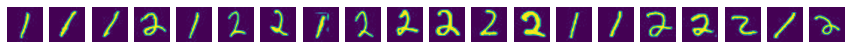

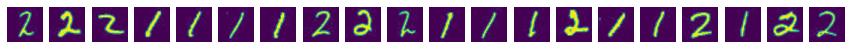

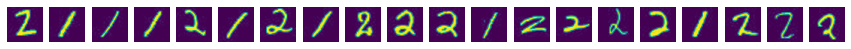

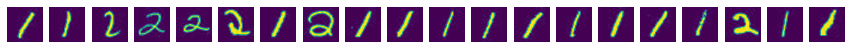

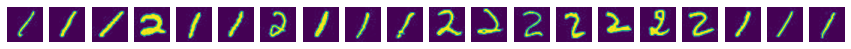

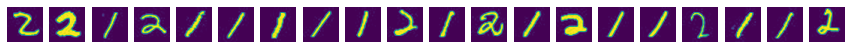

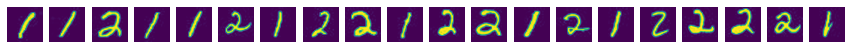

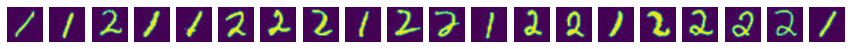

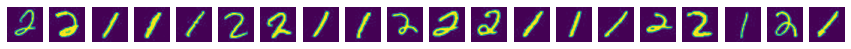

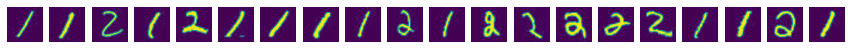

In [ ]:
imgs = []
for img, _ in tloaderonline:
    imgs.append(img[0][0])
showparts(imgs, 20)

Segundo dataset, com numeros 1 levemente inclinados para esqueda\ chamaremos de Conjunto B

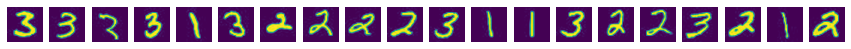

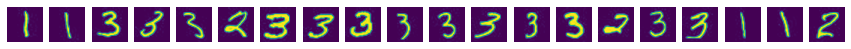

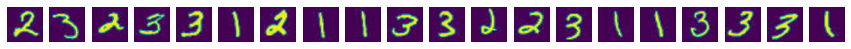

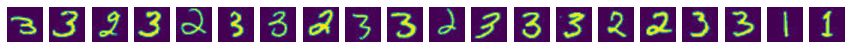

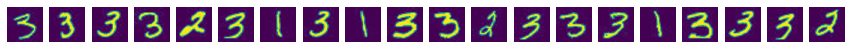

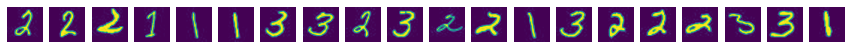

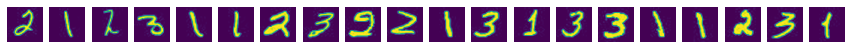

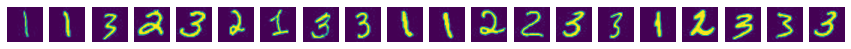

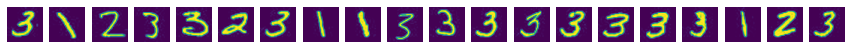

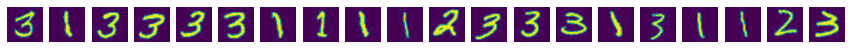

In [ ]:
imgs = []
for img, _ in tloaderonlinenew:
    imgs.append(img[0][0])
showparts(imgs, 20)

**REDE CNN COM 3 CAMADAS**

In [ ]:
class netmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.histloss = []
        ksize = 3 # or (3,3)
        nfilter = 32
        self.conv1 = nn.Conv2d(1, nfilter, ksize, padding=0)
        self.pool = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(32, 64, ksize)
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(64 * (10*10), 128) 
        self.linear2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 2) 

        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.out.weight)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = self.flatten(X) # ou X.view(-1,5*5*64)

        X = F.relu(self.linear1(X)) 
        X = F.relu(self.linear2(X)) 
        X = self.out(X) 

        #return X
        return F.log_softmax(X, dim=1) #  Não é necessário usar log_softmax, mas deixou o aprendizado mais estável

In [ ]:
def pred(model, img):
    with torch.no_grad(): # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
        logps = model(img) # output do modelo em escala logaritmica

    ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
    probabs = list(ps.cpu().numpy()[0]) # converte o tensor em um número
    return probabs.index(max(probabs)), probabs # Retorna o mais provavel junto com todas as probabilidades

In [ ]:
def validacao(modelo, valloader, device, nome=""):
    ctdcorretas, ctdtodas = 0, 0
    for imagens, rotulos in valloader:
      for i in range(len(rotulos)):
        img = imagens[i].view(1, 1, 48, 48)
                
        r_pred, _ = pred(modelo, img.to(device)) # converte o tensor em um número, no caso, o número que o modelo previu como correto 
        r_certo = rotulos.numpy()[i] 
        if(r_certo == r_pred): # compara a previsão com o valor correto
          ctdcorretas += 1
        #else: plt.imshow(img[0][0])
        ctdtodas += 1
        

    print(nome + "Imagens testadas =", ctdtodas,". Precisão = {}%".format(ctdcorretas*100/ctdtodas)) 
    return ctdcorretas*100/ctdtodas

In [ ]:
def treino(modelo, trainloader, device, otimizador, EPOCHS = 10, intervalomostra = 1):
    
    inicio = time() # timer para sabermos quanto tempo levou o treino
    
    criterio = nn.CrossEntropyLoss() 
    #criterio = nn.NLLLoss() 

    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicialização da perda acumulada da epoch em questão
        
        for imagens, rotulos in trainloader:            
            otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior
            
            output = modelo(imagens.to(device)) # colocando os dados no modelo

            #out =[max(v) for v in torch.exp(output).cpu().detach().numpy()]
            #out = torch.tensor(out).cuda()
            perda_instantanea = criterio(output, rotulos.to(device)) # calculando a perda da epoch em questão
            
            perda_instantanea.backward() # back propagation a partir da perda
            
            otimizador.step() # atualizando os pesos e a bias
            
            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada        
        
        else:
            if (epoch % intervalomostra) == 0:
                print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
            modelo.histloss.append(perda_acumulada/len(trainloader))
    print("\nTempo de treino (em minutos) =",(time()-inicio)/60)

Primeiros testes com o otimizador SGD

In [ ]:
def getoptmSGD(modelo, _lr=0.0001):
    return optim.SGD(modelo.parameters(), lr=_lr, momentum=0.9) # define a política de atualização dos pesos e da bias

def getoptmAdamW(modelo, _lr=0.0001):
    return torch.optim.AdamW(modelo.parameters(), lr=_lr)

**Função para adicionar mais um neuronio de saida na ultima camada da rede para incremento da nova classe**

In [ ]:
def camadainc(_net, device):
    wgts = _net.out.weight.data # Para copiar os pesos
    bsout = _net.out.bias.data

    # Add uma saida na ultima camada
    nout_features = _net.out.out_features
    _net.out = nn.Linear(_net.out.in_features, nout_features + 1)
    _net.out.to(device)
    with torch.no_grad():
        _net.out.weight[:nout_features] = wgts # Restaurar os pesos na nova camada
        _net.out.bias[:nout_features] = bsout

# Treinamento em Batch (Offline)

Primeiro Treino
Epoch 1 - Perda resultante: 0.6738644327436175
Epoch 21 - Perda resultante: 0.4536954164505005
Epoch 41 - Perda resultante: 0.26230048494679586
Epoch 61 - Perda resultante: 0.1398001600589071
Epoch 81 - Perda resultante: 0.07560400451932635

Tempo de treino (em minutos) = 0.2865760087966919
Conjunto A: Imagens testadas = 100 . Precisão = 100.0%
Conjunto B: Imagens testadas = 100 . Precisão = 25.0%

Segundo Treino
Epoch 1 - Perda resultante: 1.4564381837844849
Epoch 21 - Perda resultante: 0.48626757093838285
Epoch 41 - Perda resultante: 0.26611162296363283
Epoch 61 - Perda resultante: 0.18700282275676727
Epoch 81 - Perda resultante: 0.14788412196295603

Tempo de treino (em minutos) = 0.15744645198186238


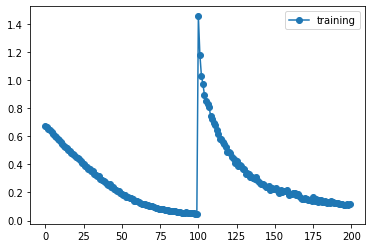

Conjunto A: Imagens testadas = 100 . Precisão = 90.0%
Conjunto B: Imagens testadas = 100 . Precisão = 99.0%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará na GPU se possível

netoff = netmodel()
netoff.to(device)

print("Primeiro Treino")
treino(netoff, tloader, device, getoptmSGD(netoff), 100, intervalomostra=20)

validacao(netoff, vloader, device, nome="Conjunto A: ")
validacao(netoff, vloadernew, device, nome="Conjunto B: ")

camadainc(netoff, device)

print("\nSegundo Treino")
treino(netoff, tloadernew, device, getoptmSGD(netoff), 100, intervalomostra=20)

plt.plot(netoff.histloss, 'o-', label='training')
plt.legend()
plt.show()

res_offa = validacao(netoff, vloader, device, nome="Conjunto A: ")
res_offb = validacao(netoff, vloadernew, device, nome="Conjunto B: ")

**Offline com AdamW**

Primeiro Treino
Epoch 1 - Perda resultante: 0.6668375049318586
Epoch 6 - Perda resultante: 0.1513233780860901
Epoch 11 - Perda resultante: 0.020839331804641655
Epoch 16 - Perda resultante: 0.008020928728261165
Epoch 21 - Perda resultante: 0.004044238760668252
Epoch 26 - Perda resultante: 0.00249489932321012

Tempo de treino (em minutos) = 0.05314486821492513
Conjunto A: Imagens testadas = 100 . Precisão = 100.0%
Conjunto B: Imagens testadas = 100 . Precisão = 26.0%

Segundo Treino
Epoch 1 - Perda resultante: 1.7175592013767786
Epoch 6 - Perda resultante: 0.544914322240012
Epoch 11 - Perda resultante: 0.3048216189656939
Epoch 16 - Perda resultante: 0.15810080298355647
Epoch 21 - Perda resultante: 0.11832732281514577
Epoch 26 - Perda resultante: 0.07363592780062131

Tempo de treino (em minutos) = 0.05826623439788818


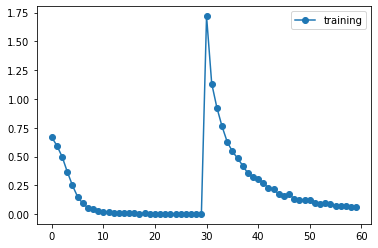

Conjunto A: Imagens testadas = 100 . Precisão = 95.0%
Conjunto B: Imagens testadas = 100 . Precisão = 98.0%


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará na GPU se possível

netoff = netmodel()
netoff.to(device)

print("Primeiro Treino")
treino(netoff, tloader, device, getoptmAdamW(netoff), 30, intervalomostra=5)

validacao(netoff, vloader, device, nome="Conjunto A: ")
validacao(netoff, vloadernew, device, nome="Conjunto B: ")

camadainc(netoff, device)

print("\nSegundo Treino")
treino(netoff, tloadernew, device, getoptmAdamW(netoff), 30, intervalomostra=5)

plt.plot(netoff.histloss, 'o-', label='training')
plt.legend()
plt.show()

resadamw_offa = validacao(netoff, vloader, device, nome="Conjunto A: ")
resadamw_offb = validacao(netoff, vloadernew, device, nome="Conjunto B: ")

# Treinamento Online

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.4850389877706766
Epoch 2 - Perda resultante: 0.13920985443517567
Epoch 3 - Perda resultante: 0.049188170754350724

Tempo de treino (em minutos) = 0.02489427328109741
Conjunto A. Imagens testadas = 100 . Precisão = 98.0%
Conjunto B. Imagens testadas = 100 . Precisão = 25.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.6334019943699241
Epoch 2 - Perda resultante: 0.2323551488877274
Epoch 3 - Perda resultante: 0.15222655904886778

Tempo de treino (em minutos) = 0.02465791702270508


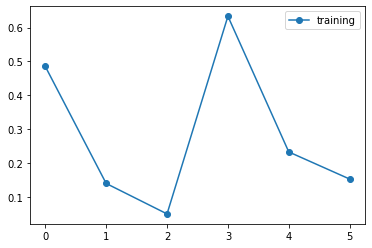


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 95.0%
Conjunto B. Imagens testadas = 100 . Precisão = 97.0%


In [ ]:
neton = netmodel()
neton.to(device)

print("======== Primeiro Treino ==========")
treino(neton, tloaderonline, device, getoptmSGD(neton), 3)

validacao(neton, vloader, device, nome = "Conjunto A. ")
validacao(neton, vloadernew, device, nome = "Conjunto B. ")

camadainc(neton, device)

print("\n======== Segundo Treino ==========")
treino(neton, tloaderonlinenew, device, getoptmSGD(neton), 3)

plt.plot(neton.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
res_ona = validacao(neton, vloader, device, nome = "Conjunto A. ")
res_onb = validacao(neton, vloadernew, device, nome = "Conjunto B. ")

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.1778455326088988
Epoch 2 - Perda resultante: 0.0037762561521324754
Epoch 3 - Perda resultante: 0.0012238148159319096

Tempo de treino (em minutos) = 0.032735435167948405
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 25.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.6314164757076651
Epoch 2 - Perda resultante: 0.18835544425877743
Epoch 3 - Perda resultante: 0.13198707375966479

Tempo de treino (em minutos) = 0.03186493317286174


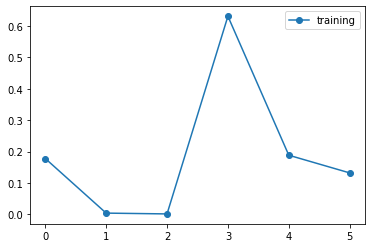


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 98.0%
Conjunto B. Imagens testadas = 100 . Precisão = 97.0%


In [ ]:
neton = netmodel()
neton.to(device)

print("======== Primeiro Treino ==========")
treino(neton, tloaderonline, device, getoptmAdamW(neton), 3)

validacao(neton, vloader, device, nome = "Conjunto A. ")
validacao(neton, vloadernew, device, nome = "Conjunto B. ")

camadainc(neton, device)

print("\n======== Segundo Treino ==========")
treino(neton, tloaderonlinenew, device, getoptmAdamW(neton), 3)

plt.plot(neton.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resadamw_ona = validacao(neton, vloader, device, nome = "Conjunto A. ")
resadamw_onb = validacao(neton, vloadernew, device, nome = "Conjunto B. ")

# EWC

In [ ]:
# Implementação adaptada com base na fonte: https://github.com/shivamsaboo17/Overcoming-Catastrophic-forgetting-in-Neural-Networks
class ElasticWeightConsolidation:

    def __init__(self, model, crit, weight=int(1e+5)):
        self.model = model
        self.weight = weight
        self.crit = crit
        # self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9) # optim.Adam(self.model.parameters(), lr)

    def _update_mean_params(self):
        for param_name, param in self.model.named_parameters():
            _buff_param_name = param_name.replace('.', '__')
            self.model.register_buffer(_buff_param_name+'_estimated_mean', param.data.clone())

    def _update_fisher_params(self, current_ds, batch_size, num_batch, device="cpu"):
        dl = current_ds
        log_liklihoods = []
        for i, (input, target) in enumerate(dl):
            if i > num_batch:
                break
            output = F.log_softmax(self.model(input.to(device)), dim=1)
            log_liklihoods.append(output[:, target.to(device)])
        log_likelihood = torch.cat(log_liklihoods).mean()        
        #log_likelihood = torch.trunc(log_likelihood*1000)/1000
        grad_log_liklihood = torch.autograd.grad(log_likelihood, self.model.parameters())
        _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
        for _buff_param_name, param in zip(_buff_param_names, grad_log_liklihood):
            self.model.register_buffer(_buff_param_name+'_estimated_fisher', param.data.clone() ** 2)

    def register_ewc_params(self, dataset, batch_size, num_batches, device="cpu"):
        self._update_fisher_params(dataset, batch_size, num_batches, device)
        self._update_mean_params()

    def _compute_consolidation_loss(self, weight):
        try:
            losses = []
            for param_name, param in self.model.named_parameters():
                _buff_param_name = param_name.replace('.', '__')
                estimated_mean = getattr(self.model, '{}_estimated_mean'.format(_buff_param_name))
                estimated_fisher = getattr(self.model, '{}_estimated_fisher'.format(_buff_param_name))
                losses.append((estimated_fisher * (param - estimated_mean) ** 2).sum())
            return (weight / 2) * sum(losses)
        except AttributeError:
            return 0

    def forward_backward_update(self, input, target, otimizador):
        output = self.model(input)
        loss = self._compute_consolidation_loss(self.weight) + self.crit(output, target)
        otimizador.zero_grad()
        loss.backward()
        otimizador.step()
        return loss

    def treino(self, dsloader, epocas, device, otimizador):
        for epoch in range(epocas):
            perda_acumulada = 0
            for input, target in dsloader:
                loss =  self.forward_backward_update(input.to(device), target.to(device), otimizador)
                #self.register_ewc_params([[input, target]], 1, 1, device)
                perda_acumulada += loss
            print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(dsloader)))
            hist = perda_acumulada/len(dsloader)
            self.model.histloss.append(hist.item())

EWC Treino

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.5702938437461853
Epoch 2 - Perda resultante: 0.269051194190979
Epoch 3 - Perda resultante: 0.09775660187005997
Epoch 4 - Perda resultante: 0.04674817994236946
Epoch 5 - Perda resultante: 0.02828953228890896
Conjunto A. Imagens testadas = 100 . Precisão = 98.0%
Conjunto B. Imagens testadas = 100 . Precisão = 25.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.8439334034919739
Epoch 2 - Perda resultante: 0.47519451379776
Epoch 3 - Perda resultante: 0.382275253534317


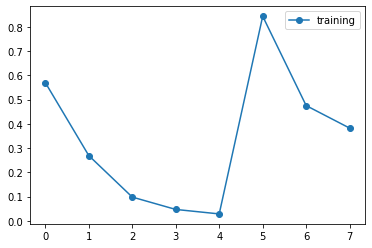


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 85.0%
Conjunto B. Imagens testadas = 100 . Precisão = 93.0%


In [ ]:
ewc = ElasticWeightConsolidation(netmodel(), crit=nn.CrossEntropyLoss())
ewc.model.to(device)

print("======== Primeiro Treino ==========")
ewc.treino(tloaderonline, 5, device, getoptmSGD(ewc.model))

validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

camadainc(ewc.model, device)
ewc.register_ewc_params(tloaderonline, 5, 100, device)

print("\n======== Segundo Treino ==========")
ewc.treino(tloaderonlinenew, 3, device, getoptmSGD(ewc.model))

plt.plot(ewc.model.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
res_ewca = validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
res_ewcb = validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

Ewc AdamW

======== Primeiro Treino ==========
Epoch 1 - Perda resultante: 0.16885685920715332
Epoch 2 - Perda resultante: 0.0053260005079209805
Epoch 3 - Perda resultante: 0.0015651488211005926
Conjunto A. Imagens testadas = 100 . Precisão = 100.0%
Conjunto B. Imagens testadas = 100 . Precisão = 26.0%

======== Segundo Treino ==========
Epoch 1 - Perda resultante: 0.7238032221794128
Epoch 2 - Perda resultante: 0.23161965608596802
Epoch 3 - Perda resultante: 0.1369704157114029


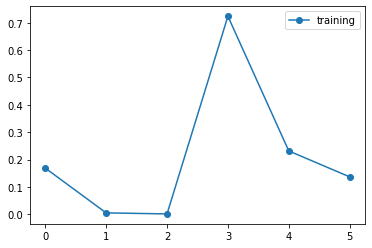


======== Resultado ==========
Conjunto A. Imagens testadas = 100 . Precisão = 93.0%
Conjunto B. Imagens testadas = 100 . Precisão = 96.0%


In [ ]:
ewc = ElasticWeightConsolidation(netmodel(), crit=nn.CrossEntropyLoss())
ewc.model.to(device)

print("======== Primeiro Treino ==========")
ewc.treino(tloaderonline, 3, device, getoptmAdamW(ewc.model))

validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

camadainc(ewc.model, device)
ewc.register_ewc_params(tloaderonline, 1, 100, device)

print("\n======== Segundo Treino ==========")
ewc.treino(tloaderonlinenew, 3, device, getoptmAdamW(ewc.model))

plt.plot(ewc.model.histloss, 'o-', label='training')
plt.legend()
plt.show()

print("\n======== Resultado ==========")
resadamw_ewca = validacao(ewc.model, vloader, device, nome = "Conjunto A. ")
resadamw_ewcb = validacao(ewc.model, vloadernew, device, nome = "Conjunto B. ")

# Resultados

In [ ]:
def byres(r):
    return r[1]

resultados = [["Offline SGD Conjunto A", res_offa]]
resultados += [["Online SGD Conjunto A", res_ona]]
resultados += [["EWC SGD Conjunto A", res_ewca]]
resultados += [["Offline AdamW Conjunto A", resadamw_offa]]
resultados += [["Online AdamW Conjunto A", resadamw_ona]]
resultados += [["EWC AdamW Conjunto A", resadamw_ewca]]

print("Resultados ordenados do pior para o melhor (Maior é melhor):")
resultados.sort(key=byres)
for res in resultados:
    print(res[0], ":", res[1])

resultados = [["Offline SGD Conjunto B", res_offb]]
resultados += [["Online SGD Conjunto B", res_onb]]
resultados += [["EWC SGD Conjunto B", res_ewcb]]
resultados += [["Offline AdamW Conjunto B", resadamw_offb]]
resultados += [["Online AdamW Conjunto B", resadamw_onb]]
resultados += [["EWC AdamW Conjunto B", resadamw_ewcb]]

print("\nResultados da acurácia do Conjunto B no segundo treinamento:")
resultados.sort(key=byres)
for res in resultados:
    print(res[0], ":", res[1])

Resultados ordenados do pior para o melhor (Maior é melhor):
EWC SGD Conjunto A : 85.0
Offline SGD Conjunto A : 90.0
EWC AdamW Conjunto A : 93.0
Online SGD Conjunto A : 95.0
Offline AdamW Conjunto A : 95.0
Online AdamW Conjunto A : 98.0

Resultados da acurácia do Conjunto B no segundo treinamento:
EWC SGD Conjunto B : 93.0
EWC AdamW Conjunto B : 96.0
Online SGD Conjunto B : 97.0
Online AdamW Conjunto B : 97.0
Offline AdamW Conjunto B : 98.0
Offline SGD Conjunto B : 99.0


De acordo com os resultados, o treinamento online sofre mais com o esquecimento catastrófico. Com o incremento de mais uma classe o esquecimento é ainda maior.
Quando o otimizador Adamw é utilizado, a performance em relação ao esquecimento tem um desempenho melhor.
Os resultados com treinamento utilizando EWC são muito variados, sendo necessário mais estudos e testes utilizando outras amostras, datasets com mais quantidades e outros modelos de rede para obter melhor compreensão sobre a vantagem de utilizar EWC nos treinos.
Com esses experimentos foi possível compreender o efeito do esquecimento catastrófico e entender também que existe estretégias para amenizar o esquecimento. Atualmente existem várias propostas além do EWC que ajudam a minimizar o esquecimento nas redes neurais, como iCarl, Lwf e GEM só para citar alguns entre os mais conhecidos. O Aprendizado Continuo é um campo de estudo das redes neurais que tem atraido cada vez mais atenção devido aos cenários existentes no mundo real.